#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 합성 특성과 이상점

 **학습 목표:**
  * 다른 두 특성의 비율로 합성 특성을 만든다
  * 새 특성을 선형 회귀 모델의 입력으로 사용한다
  * 입력 데이터에서 이상점을 식별 및 삭제하여 모델의 효율성을 개선한다

 텐서플로우 첫걸음 실습에서 사용한 모델을 다시 살펴보겠습니다.

우선 캘리포니아 주택 데이터를 *pandas* `DataFrame`으로 가져옵니다.

 ## 설정

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

TensorFlow 1.x selected.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
6890,-118.3,33.8,13.0,3569.0,924.0,2159.0,880.0,3.2,224.2
11588,-121.3,38.6,17.0,1671.0,378.0,848.0,351.0,3.1,112.5
265,-116.6,34.0,20.0,260.0,67.0,69.0,50.0,3.5,76.6
8280,-118.5,34.2,22.0,2516.0,826.0,3350.0,713.0,2.0,158.3
1187,-117.1,32.8,33.0,2731.0,456.0,1263.0,445.0,4.6,175.3
...,...,...,...,...,...,...,...,...,...
14961,-122.2,38.1,52.0,2111.0,310.0,772.0,323.0,4.8,148.2
746,-117.1,33.2,4.0,5465.0,974.0,2844.0,950.0,4.4,174.8
9412,-119.2,36.5,36.0,1508.0,323.0,1283.0,312.0,2.1,60.0
16736,-122.9,38.4,22.0,2900.0,538.0,1445.0,515.0,4.5,296.8


 다음으로, 입력 함수를 설정하고 모델 학습용 함수를 정의합니다.

In [2]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [3]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

 ## 작업 1: 합성 특성 사용해 보기

`total_rooms` 특성과 `population` 특성은 모두 특정 지역의 합계를 계수합니다.

그런데 지역마다 인구밀도가 다르다면 어떻게 될까요? `total_rooms`와 `population`의 비율로 합성 특성을 만들면 지역의 인구밀도와 주택 가격 중앙값의 관계를 살펴볼 수 있습니다.

아래 셀에서 `rooms_per_person`이라는 특성을 만들고 `train_model()`의 `input_feature`로 사용합니다.

학습률을 조정하여 이 단일 특성으로 성능을 어디까지 올릴 수 있을까요? 성능이 높다는 것은 회귀선이 데이터에 잘 부합하고 최종 RMSE가 낮다는 의미입니다.

 **참고**: 아래에 코드 셀을 몇 개 추가하여 다양한 학습률을 실험하면서 결과를 비교해 보면 도움이 됩니다. 새 코드 셀을 추가하려면 이 셀 가운데 바로 아래에 마우스를 가져가고 **CODE**를 클릭합니다.

Training model...
RMSE (on training data):
  period 00 : 190.77
  period 01 : 152.61
  period 02 : 133.60
  period 03 : 131.65
  period 04 : 133.96
  period 05 : 134.26
  period 06 : 134.51
  period 07 : 134.39
  period 08 : 134.08
  period 09 : 134.13
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,211.1,207.3
std,95.4,116.0
min,50.8,15.0
25%,173.6,119.4
50%,207.8,180.4
75%,236.9,265.0
max,4557.1,500.0


Final RMSE (on training data): 134.13


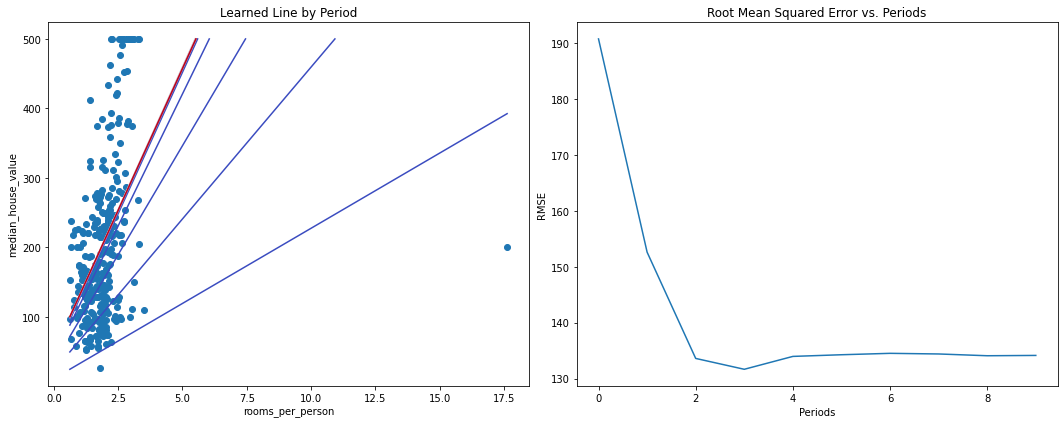

In [6]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"]

calibration_data = train_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=10,
    input_feature="rooms_per_person"
)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

Training model...
RMSE (on training data):
  period 00 : 213.48
  period 01 : 190.32
  period 02 : 170.55
  period 03 : 154.52
  period 04 : 141.81
  period 05 : 133.91
  period 06 : 131.12
  period 07 : 130.58
  period 08 : 130.75
  period 09 : 130.96
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,194.6,207.3
std,88.2,116.0
min,46.6,15.0
25%,160.0,119.4
50%,191.6,180.4
75%,218.5,265.0
max,4208.8,500.0


Final RMSE (on training data): 130.96


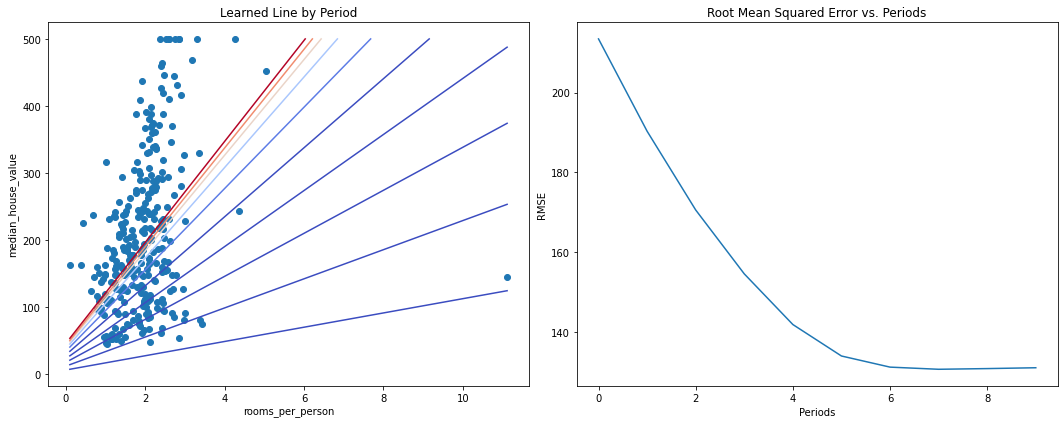

In [4]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

 ## 작업 2: 이상점 식별

예측과 목표값을 비교한 산포도를 작성하면 모델의 성능을 시각화할 수 있습니다.  이상적인 상태는 완벽한 상관성을 갖는 대각선이 그려지는 것입니다.

작업 1에서 학습한 rooms-per-person 모델을 사용한 예측과 타겟에 대해 Pyplot의 `scatter()`로 산포도를 작성합니다.

특이한 점이 눈에 띄나요? `rooms_per_person`의 값 분포를 조사하여 소스 데이터를 추적해 보세요.

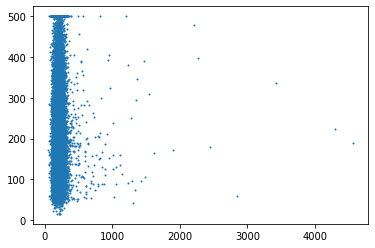

In [12]:
# YOUR CODE HERE
plt.scatter(calibration_data["predictions"], calibration_data["targets"], s=1) 

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

 보정 데이터를 보면 대부분의 산포점이 직선을 이룹니다. 이 선은 수직에 가까운데, 여기에 대해서는 나중에 설명합니다. 지금은 선에서 벗어난 점에 대해 집중할 때입니다. 이러한 점은 비교적 적은 편입니다.

`rooms_per_person`의 히스토그램을 그려보면 입력 데이터에서 몇 개의 이상점을 발견할 수 있습니다.

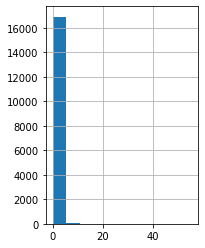

In [16]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

 ## 작업 3: 이상점 삭제

`rooms_per_person`의 이상점 값을 적당한 최소값 또는 최대값으로 설정하여 모델의 적합성을 더 높일 수 있는지 살펴보세요.

다음은 Pandas `Series`에 함수를 적용하는 방법을 간단히 보여주는 예제입니다.

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

위와 같은 `clipped_feature`는 `0` 미만의 값을 포함하지 않습니다.

In [18]:
x = california_housing_dataframe["rooms_per_person"]
m = np.mean(x)
stdev = np.std(x)
z_scores = (x - m) / stdev
clipped_feature = z_scores.apply(lambda x: min(x, 3) )

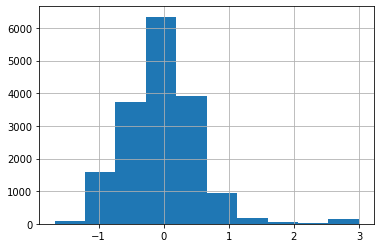

In [19]:
clipped_feature.hist()

In [ ]:
clipped_feature = my_dataframe["rooms_per_person"].apply(lambda x: max())

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 작업 2에서 작성한 히스토그램을 보면 대부분의 값이 `5` 미만입니다. `rooms_per_person`을 5에서 잘라내고 히스토그램을 작성하여 결과를 다시 확인해 보세요.

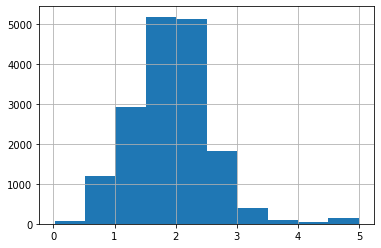

In [20]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

 삭제가 효과가 있었는지 확인하기 위해 학습을 다시 실행하고 보정 데이터를 한 번 더 출력해 보겠습니다.

Training model...
RMSE (on training data):
  period 00 : 212.80
  period 01 : 189.07
  period 02 : 166.73
  period 03 : 147.22
  period 04 : 131.51
  period 05 : 118.59
  period 06 : 113.21
  period 07 : 110.41
  period 08 : 109.34
  period 09 : 108.01
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,198.4,207.3
std,51.9,116.0
min,46.0,15.0
25%,165.2,119.4
50%,198.4,180.4
75%,226.7,265.0
max,440.7,500.0


Final RMSE (on training data): 108.01


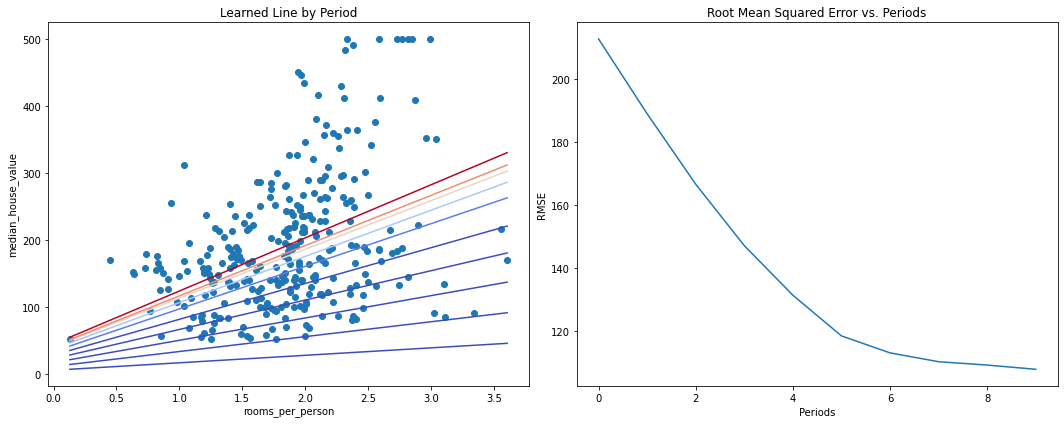

In [21]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

In [ ]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])